# Majority Voting Experiments

Majority voting is the default voting technique used in simple crowdsourcing systems.
In this notebook, we also experiment with a few simple techniques which rely on also looking at similar documents when aggregating votes.

Good for looking at one topic at a time. For experiments over all topics, Euler is preferred!


## TODO
 * Aggregate over topics and repeats (50-60ish)
 * Plot multiple curves on same graph.
 * RMSE evaluation of MVNN, compared to data in paper.
 * Sort out some of the code duplication.

In [1]:
%load_ext autoreload

In [2]:
from collections import OrderedDict
from datetime import datetime
import io
import os
import random
import sys

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

print("Current Python: {0}".format(sys.executable))

# This makes Jupyter pretend to be Pythonic and play well with modules.
sys.path.append(os.path.expandvars(os.path.join(os.getcwd(), '..')))

Current Python: /Users/andrei/anaconda3/envs/crowd/bin/python


In [3]:
if 'notebooks' in os.getcwd():
    print(os.getcwd())
    os.chdir('..')
    print(os.getcwd())

/Users/andrei/workspace/crowd/notebooks
/Users/andrei/workspace/crowd


In [4]:
np.random.seed(0xF00F1E2)
random.seed(0xF00F1E2)

In [5]:
from crowd.aggregation import *
from crowd.data import *
from crowd.config import *
from crowd.file_util import *
from crowd.graph import *
from crowd.graph_sampling import *
from crowd.simulation import *
from crowd.topic import *
from crowd.util import *

/Users/andrei/anaconda3/envs/crowd/lib/python3.6/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


## Load data

In [7]:
SIM_THRESHOLD = 0.5
DISCARD_EMPTY_NODES = True

id_topic_info = load_topic_metadata()

# TODO(andrei): Better names for these!
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)
test_data = read_ground_truth()

# TODO(andrei): Consider parallelizing this somehow.
id_topic_nx_graph = {topic_id: build_nx_document_graph(topic,
                                                       test_data,
                                                       get_topic_judgements_by_doc_id(topic_id, judgements),
                                                       FULLTEXT_FOLDER,
                                                       sim_threshold=SIM_THRESHOLD,
                                                       discard_empty=DISCARD_EMPTY_NODES)
                     for topic_id, topic in id_topic_info.items()}
id_topic_graph = {topic_id: build_document_graph(topic, FULLTEXT_FOLDER, sim_threshold=SIM_THRESHOLD)
                  for topic_id, topic in id_topic_info.items()}

Building nx doc graph
6 relevant documents
4 non-relevant documents
100 documents with votes
99 hidden nodes (due to no data)
Building nx doc graph
6 relevant documents
4 non-relevant documents
110 documents with votes
81 hidden nodes (due to no data)
Building nx doc graph
10 relevant documents
5 non-relevant documents
115 documents with votes
54 hidden nodes (due to no data)
Building nx doc graph
26 relevant documents
9 non-relevant documents
105 documents with votes
56 hidden nodes (due to no data)
Building nx doc graph
7 relevant documents
3 non-relevant documents
100 documents with votes
82 hidden nodes (due to no data)
Building nx doc graph
13 relevant documents
2 non-relevant documents
115 documents with votes
95 hidden nodes (due to no data)
Building nx doc graph
8 relevant documents
7 non-relevant documents
105 documents with votes
59 hidden nodes (due to no data)
Building nx doc graph
11 relevant documents
4 non-relevant documents
115 documents with votes
156 hidden nodes (due

In [8]:
print("{0} total useful votes, a.k.a. judgements.".format(len(judgements)))

46319 total useful votes, a.k.a. judgements.


## Majority Voting Aggregation

In [11]:
# Code moved to 'aggregation.py'.

## MV with Nearest Neighbor

* for all $i \in I$ (documents) do
    * if $i$ has no votes
        * $\hat{p_i} \leftarrow 0.5$
    * else
        * if $\rho(d_i, d_{o^i(2)}) > \rho_s$ then
            * $\hat{p_i} \leftarrow \overline{V_i \cup V_{o^i(2)}}$
        * else
            * $\hat{p_i} \leftarrow \overline{V_i}$
        * end if
    * end if
* end for

In [12]:
# Code moved to 'aggregation.py'.

In [13]:
from crowd.experiment_config import ExperimentConfig

In [14]:
# LV = LeastVotesSampler(), the vanilla sampling technique.

mv_config = ExperimentConfig(aggregate_MV, "LV-MV", {})
mv_nn_config = ExperimentConfig(aggregate_MV_NN, "LV-MVNN(0.5)", {'rho_s': 0.5})
mv_nn_09_config = ExperimentConfig(aggregate_MV_NN, "LV-MVNN(0.9)", {'rho_s': 0.9})

mvpp_graph_opts={'marker': 'x', 'markevery': 15}
mv_nn_plus = ExperimentConfig(aggregate_MV_NN, "LV-MVNN+(0.9)", {'rho_s': 0.9, 'seek_good_neighbor': True}, graph_opts=mvpp_graph_opts)
mv_nn_plus_hardcore = ExperimentConfig(aggregate_MV_NN, "LV-MVNN+(0.995)", {'rho_s': 0.995, 'seek_good_neighbor': True}, graph_opts=mvpp_graph_opts)

mev_graph_opts = {'marker': '^', 'markevery': 15}
mev_1_config = ExperimentConfig(aggregate_mev, "LV-MEV(1)", {'C': 1}, graph_opts=mev_graph_opts)
mev_2_config = ExperimentConfig(aggregate_mev, "LV-MEV(2)", {'C': 2}, graph_opts=mev_graph_opts)
mev_3_config = ExperimentConfig(aggregate_mev, "LV-MEV(3)", {'C': 3}, graph_opts=mev_graph_opts)
mev_4_config = ExperimentConfig(aggregate_mev, "LV-MEV(4)", {'C': 4}, graph_opts=mev_graph_opts)
mev_5_config = ExperimentConfig(aggregate_mev, "LV-MEV(5)", {'C': 5}, graph_opts=mev_graph_opts)


def plot_topic(topic_id, experiments, max_votes, iterations, **kw):
    topic_judgements = get_topic_judgements_by_doc_id(topic_id, judgements)
    document_count = len(topic_judgements)
    cframe = pd.DataFrame()
    
    ax = None
    for cfg in experiments:
        if cfg.nx_graph:
            print("Using NetworkX graph.")
            graph = id_topic_nx_graph[topic_id]
        else:
            print("Using oldschool graph.")
            graph = id_topic_graph[topic_id]
            
        subframe = learning_curve_frame(
            graph,
            cfg.vote_aggregator,
            cfg.name,
            document_count,
            judgements,
            test_data,     # The ground truth.
            cfg.document_sampler,
            iterations=iterations,
            max_votes=max_votes,
            sample_count=kw.get('sample_count'),
            **cfg.params)
        cframe = pd.concat([cframe, subframe])
        ax = subframe.plot(fontsize=12, ax=ax, **cfg.graph_opts)
        
    ax.set_xlabel("Mean votes per document", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    now = datetime.now()
    title = "Topic: {} (ID#{}); Date: {}; Git: {}; Graph similarity threshold: {}; Iterations: {}".format(
        id_topic_info[topic_id].query,
        topic_id,
        now.strftime("%Y-%m-%d %H:%M"),
        get_git_revision_hash(),
        id_topic_graph[topic_id].sim_threshold,
        iterations)
    ax.set_title(title, fontsize=14)
    ax.grid()
    ax.legend(loc='lower right', fontsize=14)
    
    # Auto-save everything we plot, even if it's crap.
    # TODO(andrei): Ensure folder exists.
    plotname = "topic-{}-{}-{}-{}-{}".format(
        topic_id,
        now.strftime("%Y%m%dT%H%M"),
        get_git_revision_hash(),
        id_topic_graph[topic_id].sim_threshold,
        iterations)
    plt.savefig('./plots/{}.svg'.format(plotname))

In [15]:
experimental_IC_config = ExperimentConfig(aggregate_mev_nx,
                                          "IC5-MEV",
                                          {},
                                          nx_graph=True,
                                          document_sampler=lgss_graph_factory(5),
                                          graph_opts={'marker': 'o', 'markevery': 15})

In [ ]:
fmt_topic = lambda t: "[%s] %s (%d)" % (t.topic_id, t.query, t.document_count)
optlist = ((fmt_topic(t), t.topic_id) for t in id_topic_info.values())
options=OrderedDict(sorted(optlist))

import pylab
pylab.rcParams['figure.figsize'] = (18, 9)

# MVNN+(0.9)
# See: 20584 with VERY FEW votes
# See: 20694 with VERY FEW votes
# See: 20780 with VERY FEW votes. Starts really sucking after 1.0, especially around 3.0.
# See: 20956: beats opponents 1-3
# 20972 Highlights poor performance of MVNN(0.5) vs MVNN(0.9)
# vice president Richard Nixon seems to yield very poor results across the board.
#     Need to manually inspect data. Perhaps it's because results about Nixon 
#     as a president seem relevant but actually are not?

@interact(
    topic_id=widgets.Dropdown(options=options, value='20704'),
    iterations=widgets.IntSlider(min=10, max=500, step=5, continuous_update=False, value=25),
    max_votes_per_doc=widgets.IntSlider(min=1, max=10, step=1, continuous_update=False, value=1)
)
def plot_proxy(topic_id, iterations, max_votes_per_doc):
    print("Iterations: %d" % iterations)
    experiments = [experimental_IC_config,
                   mev_1_config,
                   mev_2_config,
                   mev_3_config]
#                    mv_config]
#                    mv_nn_config,
#                    mv_nn_plus,
#                    mv_nn_plus_hardcore,
#                    mev_1_config,
#                    mev_2_config,
#                    mev_3_config]
    plot_topic(topic_id, experiments, max_votes_per_doc, iterations, sample_count=750)

## Aggregation over topics

Very slow to compute. Should calculate on Euler.

In [70]:
cross_topic_experiments = [
    mv_config, mv_nn_config, mv_nn_plus, mv_nn_plus_hardcore,
    mev_1_config, mev_2_config, mev_3_config]

cross_topic_experiments = [
    experimental_IC_config,
    mv_config,
    mev_1_config]
    
upto = 1   # votes per document
iterations = 15
all_frames = compute_cross_topic_learning(cross_topic_experiments,
                                          upto, iterations, topic_limit=3)

Processing aggregator: IC5-MEV.
Processing topic number 0/30.
Processing topic number 1/30.
Processing topic number 2/30.
Processing topic number 3/30.
Reached limit. Stopping.
(4, 100)
Processing aggregator: MV.
Processing topic number 0/30.
Processing topic number 1/30.
Processing topic number 2/30.
Processing topic number 3/30.
Reached limit. Stopping.
(4, 100)
Processing aggregator: MEV(1).
Processing topic number 0/30.
Processing topic number 1/30.
Processing topic number 2/30.
Processing topic number 3/30.
Reached limit. Stopping.
(4, 100)


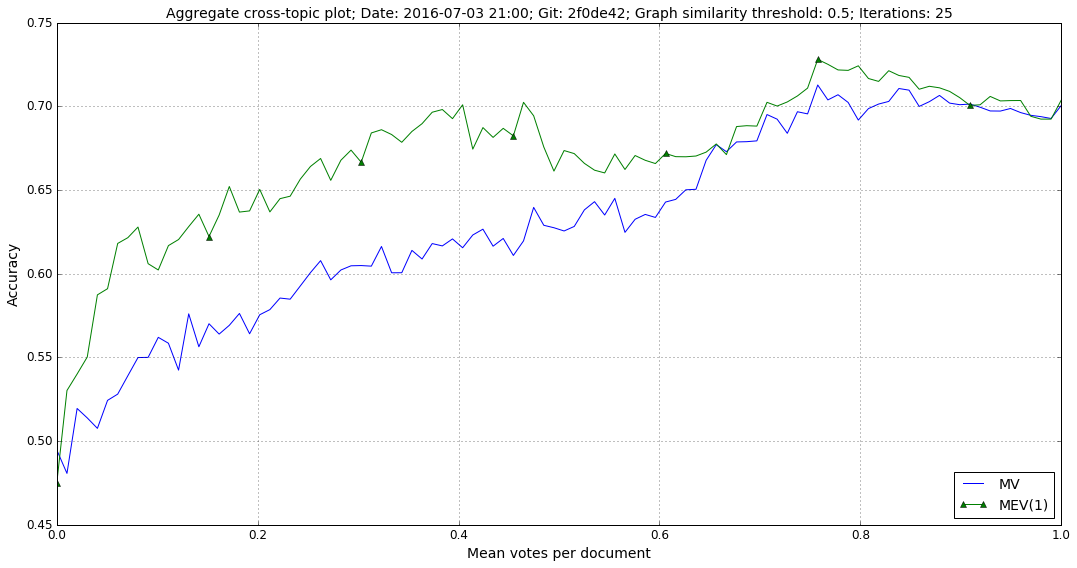

In [69]:
plot_cross_topic_learning(all_frames, upto, iterations)

## Comparison with paper gold standard

NB: This code is rather old and may no longer work correctly.

In [ ]:
after_one_vote = {}
topic_count = len(id_topic_info)

for i, (topic_id, topic) in enumerate(id_topic_info.items()):
    print("Topic %d/%d" % (i + 1, topic_count))
    data = build_learning_curve(
        topic_id,
        aggregate_MV,
        iterations=1000,
        max_votes=1,
        progress_every=-1)

    after_one_vote[topic_id] = data[-1]    

In [ ]:
paper_standard_mv = {
    '20424': 0.594,
    '20488': 0.667,
    '20542': 0.676,
    '20584': 0.689,
    '20636': 0.716,
    '20642': 0.693,
    '20686': 0.693,
    '20690': 0.703,
    '20694': 0.726,
    '20696': 0.562,
    '20704': 0.670,
    '20714': 0.808,
    '20764': 0.676,
    '20766': 0.796,
    '20778': 0.652,
    '20780': 0.641,
    '20812': 0.688,
    '20814': 0.792,
    '20832': 0.630,
    '20910': 0.661,
    '20916': 0.650,
    '20932': 0.576,
    '20956': 0.616,
    '20958': 0.610,
    '20962': 0.552,
    '20972': 0.668,
    '20976': 0.632,
    '20996': 0.542
}

# TODO(andrei) 
paper_standard_mvnn_05 = {
    '20424': 0.608,
    '20488': 0.722,
    '20542': 0.673,
    '20584': 0.761, #*
    '20636': 0.774, #*
    '20642': 0.756, #*
    '20686': 0.639,
    
    '20690': 0.744, #*
    '20694': 0.746,
    '20696': 0.622,
    '20704': 0.790, #*
    '20714': 0.818,
    '20764': 0.600,
    '20766': 0.794,
    '20778': 0.662,
    '20780': 0.732, #*
    '20812': 0.695,
    '20814': 0.770,
    '20832': 0.642,
    '20910': 0.643,
    '20916': 0.638,
    '20932': 0.540,
    '20956': 0.646,
    '20958': 0.556,
    '20962': 0.610,
    '20972': 0.632,
    '20976': 0.620,
    '20996': 0.504
}

def rmse_own_results(own_result_map):
    rmse = 0.0
    for topic_id, mv_score in paper_standard_mv.items():
        rmse += abs(own_result_map[topic_id] - mv_score) ** 2
    
    rmse /= len(paper_standard_mv)
    return rmse

In [ ]:
print(rmse_own_results(after_one_vote))

### RMSE for MV
* rmse = 0.44473 when comparing all votes to 0.0
* rmse = 0.03119 when comparing all votes to 0.5
* rmse = 0.01002 when running 500 iterations (30 Apr)
* rmse = 0.00989 when running 1000 iterations (30 Apr)